In [1]:
import dataclasses
import itertools

import astropy.coordinates as ac
import astropy.time as at
import astropy.units as au
import jax
import jax.numpy as jnp
import numpy as np
import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from tomographic_kernel.frames import ENU

from dsa2000_cal.assets.content_registry import fill_registries
from dsa2000_cal.assets.registries import array_registry
from dsa2000_cal.common.mixed_precision_utils import mp_policy
from dsa2000_cal.common.quantity_utils import quantity_to_jnp

tfpd = tfp.distributions

2024-09-20 22:12:14.921560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 22:12:14.938808: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 22:12:14.943586: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 22:12:15.939397: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/albert/git/DSA2000-Cal/dsa2000_cal/dsa2000_cal/common/mixed_precision_utils.py:9: UserWarning: JAX x64 is not enabled. Setting it now, but check for errors.
  warnings.warn("JAX x64 is not enabled. Setting it now, but check for errors.

In [34]:

import warnings


@dataclasses.dataclass(eq=False)
class OptimisationProblem:
    batch_size: int = 1024
    num_radial_bins: int = 10
    num_theta_bins: int = 10
    lmax: au.Quantity = 1 * au.arcmin
    lmin: au.Quantity = 8 * au.arcsec
    fwhm: au.Quantity = 3.3 * au.arcsec
    freq: au.Quantity = 700 * au.MHz
    goal_far_sidelobe_dynamic_range: float = 1e-6
    fwhm_error_scale: float = np.log(1. + 0.05)
    sidelobe_error_scale: float = np.log(10.)

    def create_data(self, antennas: ac.EarthLocation, obstime: at.Time, array_location: ac.EarthLocation):
        lmax = quantity_to_jnp(self.lmax, 'rad')
        lmin = quantity_to_jnp(self.lmin, 'rad')
        fwhm = quantity_to_jnp(self.fwhm, 'rad')
        radii = jnp.concatenate([0.5 * fwhm[None], jnp.linspace(lmin, lmax, self.num_radial_bins)])
        theta = jnp.linspace(0., 2 * np.pi, self.num_theta_bins)

        R, Theta = jnp.meshgrid(
            radii, theta,
            indexing='ij'
        )

        L = R * jnp.cos(Theta)
        M = R * jnp.sin(Theta)
        lm = jnp.stack([L, M], axis=-1)  # [Nr, Nt, 2]

        antenna_enu_xyz = antennas.get_itrs(
            obstime=obstime, location=array_location).transform_to(
            ENU(obstime=obstime, location=array_location)).cartesian.xyz.to('m').T

        antennas0 = quantity_to_jnp(antenna_enu_xyz, 'm')[:, :2]  # [N, 2]
        n = antennas0.shape[0]

        antenna1, antenna2 = jnp.asarray(list(itertools.combinations_with_replacement(range(n), 2)),
                                         dtype=mp_policy.index_dtype).T

        freq = quantity_to_jnp(self.freq, 'Hz')

        return antennas0, antenna1, antenna2, lm, freq

    @staticmethod
    def compute_mu_sigma_X(mu_Y, sigma_Y):
        # Compute the standard deviation of X
        sigma_X = jnp.sqrt(jnp.log(1 + (sigma_Y ** 2) / (mu_Y ** 2)))

        # Compute the mean of X
        mu_X = jnp.log(mu_Y) - 0.5 * (sigma_X ** 2)

        return mu_X, sigma_X

    def compute_psf_from_uvw(self, uv, lm: jax.Array, freq: jax.Array):
        wavelength = mp_policy.cast_to_length(299792458. / freq)
        uv /= wavelength
        row = uv.shape[0]

        extra = row % self.batch_size
        if extra != 0:
            warnings.warn(f'Extra {extra} rows will be ignored')
            uv = uv[:row - extra]

        # Split uv into batches
        uv_batches = uv.reshape(row // self.batch_size, self.batch_size, 2)  # [Nb, batch_size, 2]

        def body(psf, uv_batch):
            delay = jnp.sum(uv_batch * lm[..., None, :], axis=-1)  # [Nr, Nt, batch_size]
            psf += mp_policy.cast_to_image(jnp.sum(jnp.cos(2 * jnp.pi * delay), axis=-1))  # [Nr, Nt]
            return psf, None

        psf_init = jnp.zeros(lm.shape[:-1], dtype=mp_policy.image_dtype)
        psf, _ = jax.lax.scan(body, psf_init, uv_batches)
        psf /= row  # normalise to unit peak
        return psf

    def compute_psf(self, antenna_locations: jax.Array, antenna1: jax.Array, antenna2: jax.Array,
                    lm: jax.Array, freq: jax.Array) -> jax.Array:
        uv = antenna_locations[antenna2] - antenna_locations[antenna1]  # [row, 2]
        return self.compute_psf_from_uvw(uv, lm, freq)

    def compute_residuals(self, antenna_locations: jax.Array, ref_psf: jax.Array, antenna1: jax.Array,
                          antenna2: jax.Array, lm: jax.Array,
                          freq: jax.Array):
        psf = jnp.log(self.compute_psf(antenna_locations, antenna1, antenna2, lm, freq))  # [Nr, Nt]
        residual_fwhm = (psf[0, :] - ref_psf[0, :]) / self.fwhm_error_scale
        # residual_wings = (psf[1:, :] - jnp.log(self.goal_far_sidelobe_dynamic_range)) / self.sidelobe_error_scale
        residual_wings = (psf[1:, :] - ref_psf[1:, :]) / self.sidelobe_error_scale
        return residual_fwhm, residual_wings


In [3]:

fill_registries()
array = array_registry.get_instance(array_registry.get_match('dsa2000W'))
antennas = array.get_antennas()
array_location = array.get_array_location()
obstime = at.Time('2021-01-01T00:00:00', format='isot', scale='utc')

problem = OptimisationProblem(num_radial_bins=10, lmax=1 * au.deg)

antennas0, antenna1, antenna2, lm, freq = problem.create_data(
    antennas=antennas, obstime=obstime, array_location=array_location
)

psf0 = jax.jit(problem.compute_psf)(antennas0, antenna1, antenna2, lm, freq)  # [Nr, Nt]


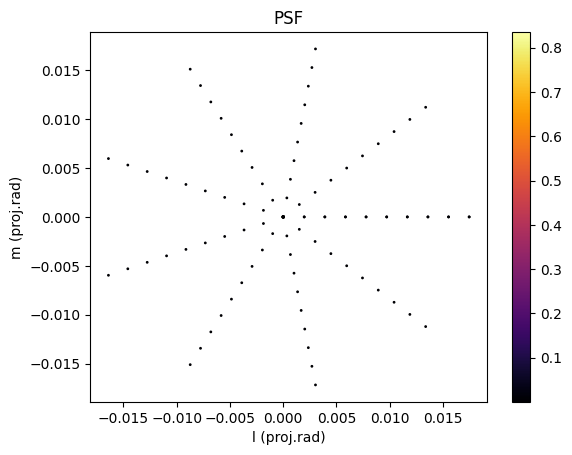

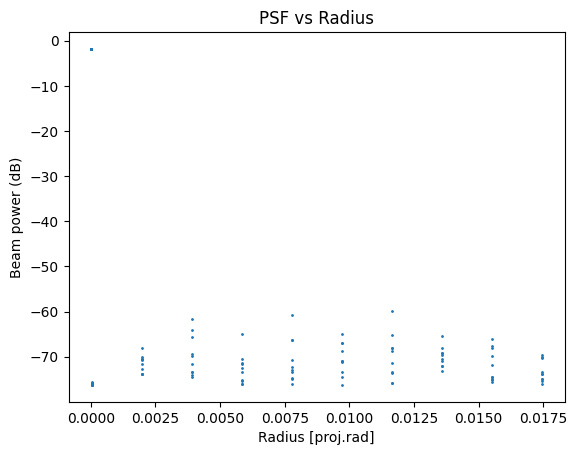

In [4]:

sc = plt.scatter(
    lm[..., 0].flatten(), lm[..., 1].flatten(), c=psf0.flatten(), s=1, cmap='inferno'
)
plt.colorbar(sc)
plt.xlabel('l (proj.rad)')
plt.ylabel('m (proj.rad)')
plt.title('PSF')
plt.show()

psf0_mean = jnp.mean(psf0, axis=-1)
psf0_std = jnp.std(psf0, axis=-1)
# Convert mean and std to log-normal
psf0_mean_log, psf0_std_log = problem.compute_mu_sigma_X(psf0_mean, psf0_std)
psf0_mean_log_dB, psf0_std_log_dB = 10 * psf0_mean_log * jnp.log(jnp.e), 10 * psf0_std_log * jnp.log(jnp.e)

radii = np.linalg.norm(lm, axis=-1).flatten()
log_psf_radii = np.log(psf0).flatten() * 10. * jnp.log(jnp.e)

plt.scatter(radii, log_psf_radii, s=1)
plt.xlabel('Radius [proj.rad]')
plt.ylabel('Beam power (dB)')
plt.title('PSF vs Radius')
plt.show()



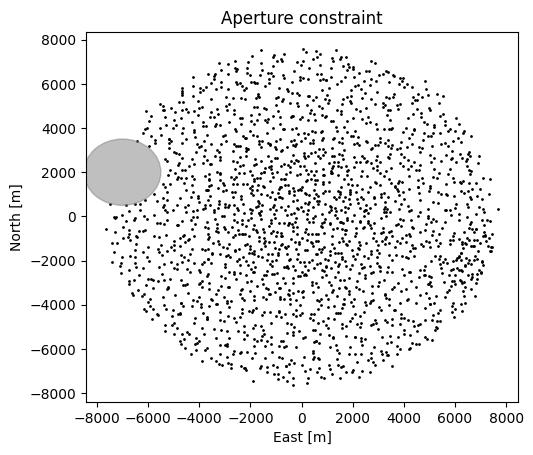

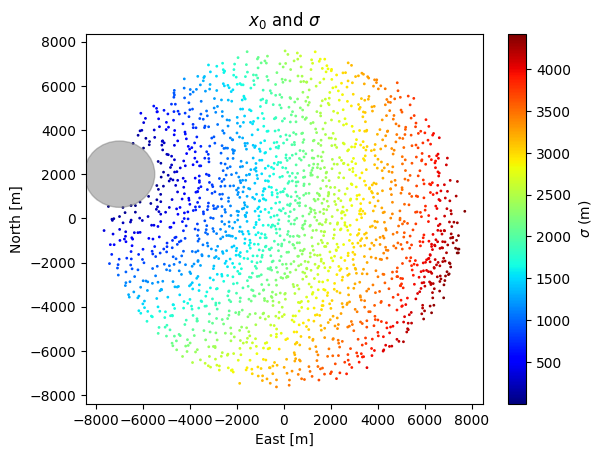

In [104]:

# Define constaints by 
from jaxns import Model, Prior

exclusion_center = jnp.asarray([-7000, 2000])
exclusion_radius = 1500
exclusion_mask = jnp.linalg.norm(antennas0 - exclusion_center, axis=-1) < exclusion_radius
# Move these antennas to another place
x0 = antennas0.at[exclusion_mask].set(-1 * antennas0[exclusion_mask])  # [n, 2]
# For sigma make the distance to exclusion center 3 sigma, from x0
sigma = 0.33 * (jnp.linalg.norm(x0 - exclusion_center, axis=-1) - exclusion_radius)  # [n]

sc = plt.scatter(x0[:, 0], x0[:, 1], s=1, c='black')
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.title(r'Aperture constraint')

# Draw grey circle for exclusion zone
circle = plt.Circle(exclusion_center, exclusion_radius, color='grey', fill=True, alpha=0.5)
plt.gca().add_artist(circle)

plt.savefig('aperture_constraint.png')
plt.subplots_adjust(right=0.8)
plt.show()

sc = plt.scatter(x0[:, 0], x0[:, 1], s=1, c=sigma, cmap='jet')
plt.colorbar(sc, label=r'$\sigma$ (m)')
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.title(r'$x_0$ and $\sigma$')

# Draw grey circle for exclusion zone
circle = plt.Circle(exclusion_center, exclusion_radius, color='grey', fill=True, alpha=0.5)
plt.gca().add_artist(circle)

plt.savefig('x0_sigma.png')
plt.show()

In [45]:


from functools import partial
from dsa2000_cal.calibration.multi_step_lm import MultiStepLevenbergMarquardt


@partial(jax.jit, static_argnums=(0,))
def solve(problem, init_state, x0, sigma, antenna1, antenna2, lm, freq, ref_psf):
    def prior_model():
        x = yield Prior(tfpd.Normal(x0, sigma[:, None]),
                        'x').parametrised()
        return x

    def log_likelihood(x):
        residuals = problem.compute_residuals(x, ref_psf, antenna1, antenna2, lm, freq)
        return sum([-jnp.sum(jnp.square(r)) for r in jax.tree.leaves(residuals)])

    model = Model(prior_model, log_likelihood)
    U = model.sample_U(jax.random.key(0))

    def residuals(params):
        (x,) = model(params).prepare_input(U)
        return problem.compute_residuals(x, ref_psf, antenna1, antenna2, lm, freq)

    solver = MultiStepLevenbergMarquardt(
        residual_fn=residuals,
        num_iterations=100,
        num_approx_steps=0,
        delta=2,
        verbose=True
    )
    if init_state is None:
        state = solver.create_initial_state(model.params)
    else:
        state = solver.update_initial_state(init_state)
    state, diagnostics = solver.solve(state)
    return model(state.x).prepare_input(U)[0], state, diagnostics


problem = OptimisationProblem(num_radial_bins=20, num_theta_bins=4, lmax=1 * au.deg)

antennas0, antenna1, antenna2, lm, freq = problem.create_data(
    antennas=antennas, obstime=obstime, array_location=array_location
)

ref_psf = jax.jit(problem.compute_psf)(antennas0, antenna1, antenna2, lm, freq)  # [Nr, Nt]

# x, state, diagnostics = solve(problem, None, x0, sigma, antenna1, antenna2, lm, freq)
x, state, diagnostics = solve(problem, state, x0, sigma, antenna1, antenna2, lm, freq, jnp.log(ref_psf))

Iter: 1, Exact Step: 0 Approx Step: 0, r: -2.085628578065382, pred: 1.8103577571981557, act: -3.775733874934824, any_improvement: False, sufficient_improvement: False, more_newton: False, less_newton: True:
	|F|^2 -> 2.306010768801473, damping -> 0.7663042329031489, mu -> 0.3323073089122772, delta_norm -> 0.015185959513628111, error -> 3.295130914465233
Iter: 2, Exact Step: 1 Approx Step: 0, r: -2.0514328506233057, pred: 1.513700476560068, act: -3.1052548836194767, any_improvement: False, sufficient_improvement: False, more_newton: False, less_newton: True:
	|F|^2 -> 2.306010768801473, damping -> 1.5326084658062977, mu -> 0.6646146178245544, delta_norm -> 0.009728932182899079, error -> 3.295130914465233
Iter: 3, Exact Step: 2 Approx Step: 0, r: -3.2094297744303955, pred: 1.2450435373451587, act: -3.995879799217694, any_improvement: False, sufficient_improvement: False, more_newton: False, less_newton: True:
	|F|^2 -> 2.306010768801473, damping -> 3.0652169316125955, mu -> 1.32922923564

In [46]:
from jaxns import save_pytree, load_pytree

save_pytree(state, 'state.json')
loaded_state = load_pytree('state.json')
loaded_state

MultiStepLevenbergMarquardtState(iteration=Array(100, dtype=int64), x={'x_param': Array([[ 0.01451474, -0.00433763],
       [ 0.06005763,  0.049288  ],
       [ 0.07337663,  0.05094041],
       ...,
       [-0.03223167,  0.01506801],
       [-0.02813961,  0.01782794],
       [-0.03344619,  0.02283108]], dtype=float64)}, delta_x={'x_param': Array([[ 9.08556730e-04, -4.07298263e-04],
       [-1.25889653e-03, -2.35963206e-05],
       [-1.30550769e-03, -1.19571625e-04],
       ...,
       [-5.26614710e-04, -3.57703884e-05],
       [-3.20385869e-05,  5.76513820e-05],
       [-3.09386699e-04,  2.77905598e-05]], dtype=float64)}, damping=Array(16.48098691, dtype=float64), F=[[Array([-0.16003256, -0.1683514 , -0.16687595, -0.16003256], dtype=float64), Array([[ 3.80315611e-01,  6.65312874e-02,  1.94565151e-01,
         3.80315611e-01],
       [ 1.10377769e-04, -7.59183679e-04, -1.47239388e-04,
         1.10377769e-04],
       [ 6.84632090e-04,  1.32536158e-05, -4.12725879e-04,
         6.8463209

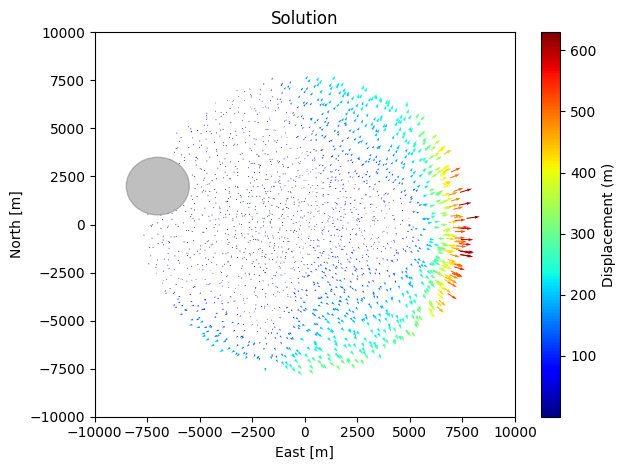

In [101]:
# Plot x0 and gradient from from x0 to x
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# plt.scatter(x0[:, 0], x0[:, 1], s=1, c=sigma, cmap='jet')
arrow_length = jnp.linalg.norm(x - x0, axis=-1)
ar = plt.quiver(x0[:, 0], x0[:, 1], x[:, 0] - x0[:, 0], x[:, 1] - x0[:, 1], arrow_length, scale=1, scale_units='xy',
                cmap='jet')
# color bar
plt.colorbar(ar, label='Displacement (m)')
# grey circle
circle = plt.Circle(exclusion_center, exclusion_radius, color='grey', fill=True, alpha=0.5)
plt.gca().add_artist(circle)
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.xlim(-10e3, 10e3)
plt.ylim(-10e3, 10e3)
plt.title('Solution')
plt.tight_layout()
plt.savefig('array_solution.png')
plt.show()

In [97]:
problem = OptimisationProblem(num_radial_bins=100, num_theta_bins=10, fwhm=3.3 * au.arcsec, lmin=3.3 * au.arcsec,
                              lmax=1 * au.arcmin)

antennas0, antenna1, antenna2, lm, freq = problem.create_data(
    antennas=antennas, obstime=obstime, array_location=array_location
)

ref_psf = jax.jit(problem.compute_psf)(antennas0, antenna1, antenna2, lm, freq)  # [Nr, Nt]
psf0 = jax.jit(problem.compute_psf)(x0, antenna1, antenna2, lm, freq)  # [Nr, Nt]
psf = jax.jit(problem.compute_psf)(x, antenna1, antenna2, lm, freq)  # [Nr, Nt]

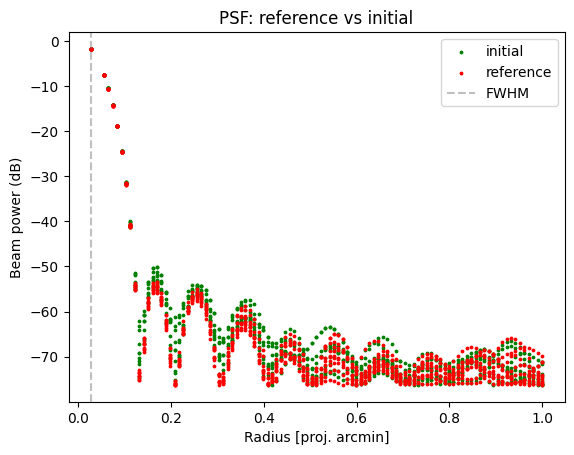

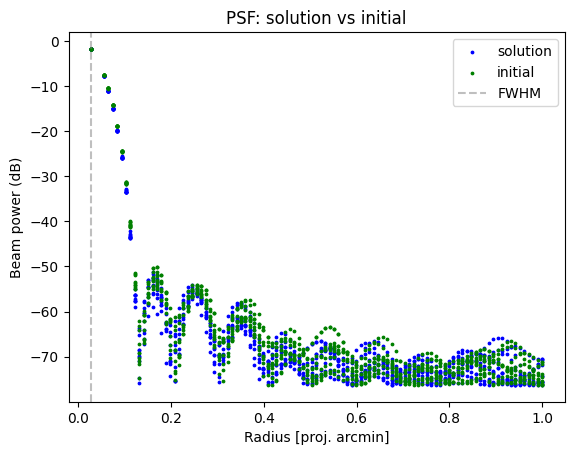

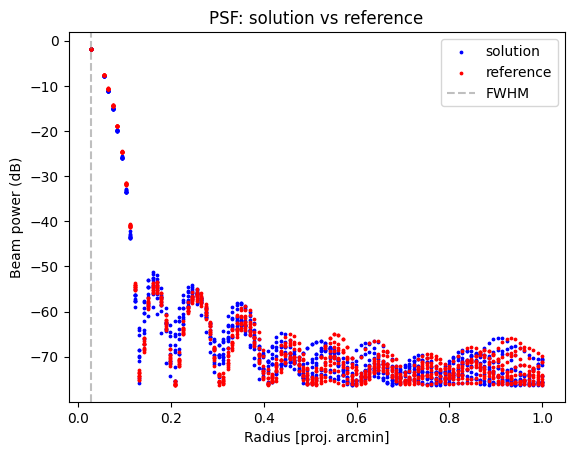

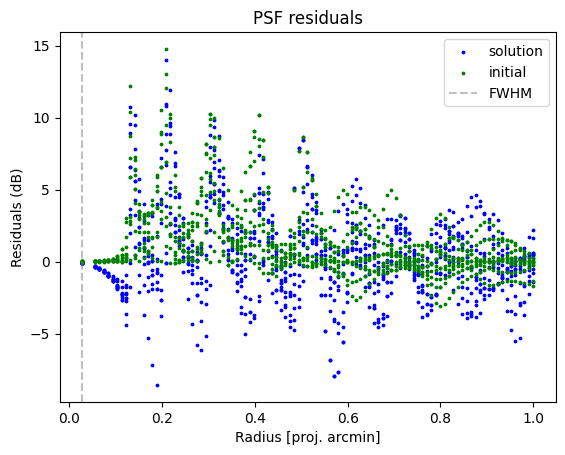

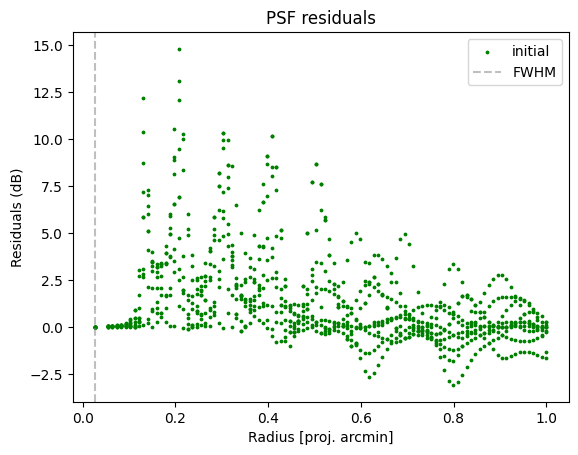

In [107]:
for _psf, name, c in (
        # [psf, 'solution', 'blue'],
        [psf0, 'initial', 'green'],
        [ref_psf, 'reference', 'red'],

):
    radii = np.linalg.norm(lm, axis=-1).flatten() * 180 / np.pi * 60
    log_psf_radii = np.log(_psf).flatten() * 10. * jnp.log(jnp.e)
    plt.scatter(radii, log_psf_radii, c=c, s=3, label=name)

plt.xlabel('Radius [proj. arcmin]')
plt.ylabel('Beam power (dB)')
plt.title('PSF: reference vs initial')
plt.axvline(3.3 / 2 / 60, color='grey', linestyle='--', label='FWHM', alpha=0.5)
plt.legend()
plt.savefig('psf_reference_vs_initial_inner.png')
plt.show()

for _psf, name, c in (
        [psf, 'solution', 'blue'],
        # [ref_psf, 'reference', 'red'],
        [psf0, 'initial', 'green'],
):
    radii = np.linalg.norm(lm, axis=-1).flatten() * 180 / np.pi * 60
    log_psf_radii = np.log(_psf).flatten() * 10. * jnp.log(jnp.e)
    plt.scatter(radii, log_psf_radii, c=c, s=3, label=name)

plt.xlabel('Radius [proj. arcmin]')
plt.ylabel('Beam power (dB)')
plt.title('PSF: solution vs initial')
plt.axvline(3.3 / 2 / 60, color='grey', linestyle='--', label='FWHM', alpha=0.5)
plt.legend()
plt.savefig('psf_solution_vs_initial_inner.png')
plt.show()

for _psf, name, c in (
        [psf, 'solution', 'blue'],
        [ref_psf, 'reference', 'red'],
        # [psf0, 'initial', 'green'],
):
    radii = np.linalg.norm(lm, axis=-1).flatten() * 180 / np.pi * 60
    log_psf_radii = np.log(_psf).flatten() * 10. * jnp.log(jnp.e)
    plt.scatter(radii, log_psf_radii, c=c, s=3, label=name)
plt.xlabel('Radius [proj. arcmin]')
plt.ylabel('Beam power (dB)')
plt.title('PSF: solution vs reference')
plt.axvline(3.3 / 2 / 60, color='grey', linestyle='--', label='FWHM', alpha=0.5)
plt.legend()
plt.savefig('psf_solution_vs_ref_inner.png')
plt.show()

residuals = (np.log(psf.flatten()) - np.log(ref_psf.flatten())) * 10. * jnp.log(jnp.e)
residuals0 = (np.log(psf0.flatten()) - np.log(ref_psf.flatten())) * 10. * jnp.log(jnp.e)
radii = np.linalg.norm(lm, axis=-1).flatten() * 180 / np.pi * 60
plt.scatter(radii, residuals, s=3, c='blue', label='solution')
plt.scatter(radii, residuals0, s=3, c='green', label='initial')
plt.xlabel('Radius [proj. arcmin]')
plt.ylabel('Residuals (dB)')
plt.title('PSF residuals')
plt.axvline(3.3 / 2 / 60, color='grey', linestyle='--', label='FWHM', alpha=0.5)
plt.legend()
plt.savefig('psf_residuals_soluion_vs_ref_inner.png')
plt.show()


residuals0 = (np.log(psf0.flatten()) - np.log(ref_psf.flatten())) * 10. * jnp.log(jnp.e)
radii = np.linalg.norm(lm, axis=-1).flatten() * 180 / np.pi * 60
plt.scatter(radii, residuals0, s=3, c='green', label='initial')
plt.xlabel('Radius [proj. arcmin]')
plt.ylabel('Residuals (dB)')
plt.title('PSF residuals')
plt.axvline(3.3 / 2 / 60, color='grey', linestyle='--', label='FWHM', alpha=0.5)
plt.legend()
plt.savefig('psf_residuals_initial_vs_ref_inner.png')
plt.show()



In [95]:
problem = OptimisationProblem(num_radial_bins=300, num_theta_bins=10, fwhm=3.3 * au.arcsec, lmin=3.3 * au.arcsec,
                              lmax=1 * au.deg)

antennas0, antenna1, antenna2, lm, freq = problem.create_data(
    antennas=antennas, obstime=obstime, array_location=array_location
)

ref_psf = jax.jit(problem.compute_psf)(antennas0, antenna1, antenna2, lm, freq)  # [Nr, Nt]
psf0 = jax.jit(problem.compute_psf)(x0, antenna1, antenna2, lm, freq)  # [Nr, Nt]
psf = jax.jit(problem.compute_psf)(x, antenna1, antenna2, lm, freq)  # [Nr, Nt]

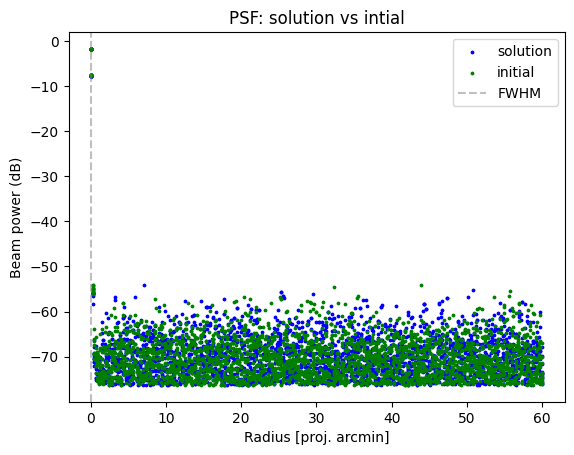

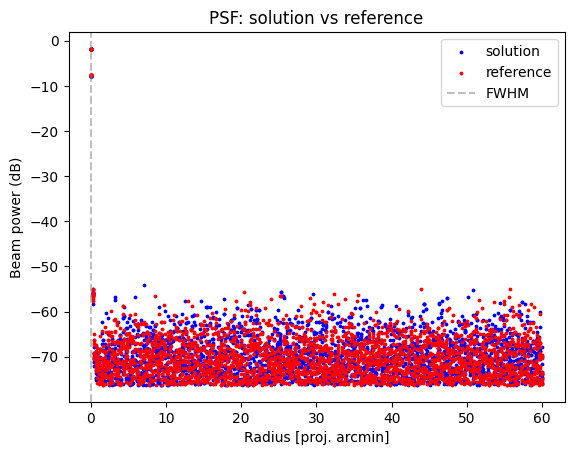

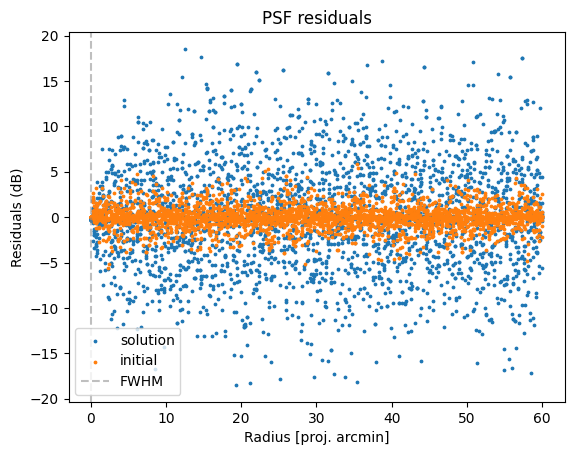

In [96]:
for _psf, name, c in (
        [psf, 'solution', 'blue'],
        # [ref_psf, 'reference', 'red'],
        [psf0, 'initial', 'green'],
):
    radii = np.linalg.norm(lm, axis=-1).flatten() * 180 / np.pi * 60
    log_psf_radii = np.log(_psf).flatten() * 10. * jnp.log(jnp.e)
    plt.scatter(radii, log_psf_radii, c=c, s=3, label=name)
plt.xlabel('Radius [proj. arcmin]')
plt.ylabel('Beam power (dB)')
plt.title('PSF: solution vs intial')
plt.axvline(3.3 / 2 / 60, color='grey', linestyle='--', label='FWHM', alpha=0.5)
plt.legend()
plt.savefig('psf_solution_vs_initial_full.png')
plt.show()

for _psf, name, c in (
        [psf, 'solution', 'blue'],
        [ref_psf, 'reference', 'red'],
        # [psf0, 'initial', 'green'],
):
    radii = np.linalg.norm(lm, axis=-1).flatten() * 180 / np.pi * 60
    log_psf_radii = np.log(_psf).flatten() * 10. * jnp.log(jnp.e)
    plt.scatter(radii, log_psf_radii, c=c, s=3, label=name)
plt.xlabel('Radius [proj. arcmin]')
plt.ylabel('Beam power (dB)')
plt.title('PSF: solution vs reference')
plt.axvline(3.3 / 2 / 60, color='grey', linestyle='--', label='FWHM', alpha=0.5)
plt.legend()
plt.savefig('psf_solution_vs_ref_full.png')
plt.show()

residuals = (np.log(psf.flatten()) - np.log(ref_psf.flatten())) * 10. * jnp.log(jnp.e)
residuals0 = (np.log(psf0.flatten()) - np.log(ref_psf.flatten())) * 10. * jnp.log(jnp.e)
radii = np.linalg.norm(lm, axis=-1).flatten() * 180 / np.pi * 60
plt.scatter(radii, residuals, s=3, label='solution')
plt.scatter(radii, residuals0, s=3, label='initial')
plt.xlabel('Radius [proj. arcmin]')
plt.ylabel('Residuals (dB)')
plt.title('PSF residuals')
plt.axvline(3.3 / 2 / 60, color='grey', linestyle='--', label='FWHM', alpha=0.5)
plt.legend()
plt.savefig('psf_residuals_soluion_vs_ref_full.png')
plt.show()



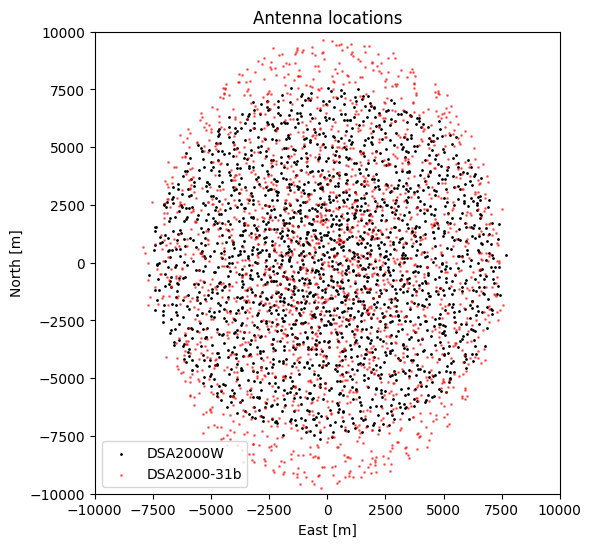

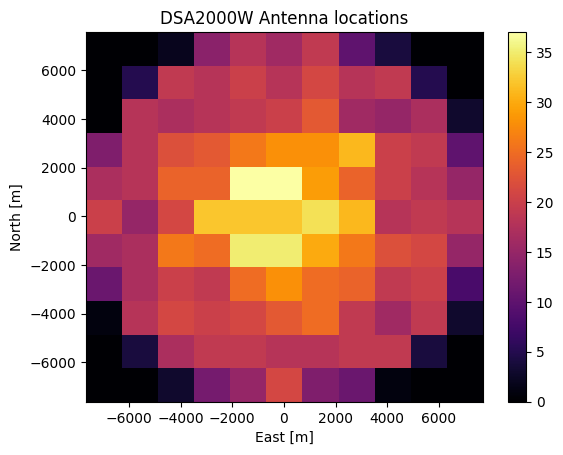

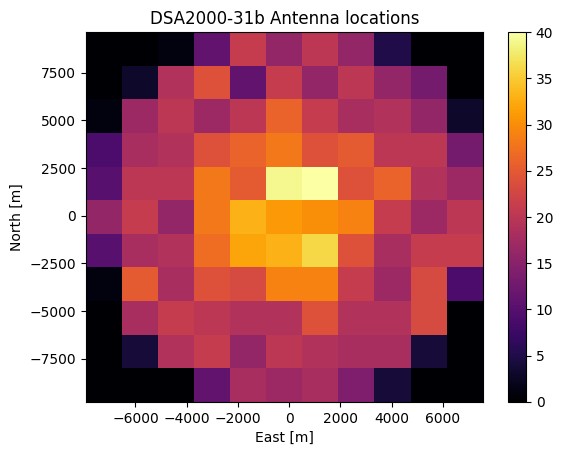

In [12]:
freq = 700 * au.MHz
fill_registries()

array0 = array_registry.get_instance(array_registry.get_match('dsa2000W'))
antennas0 = array0.get_antennas()
location = array0.get_array_location()
obstime = at.Time('2021-01-01T00:00:00', format='isot', scale='utc')

antennas0_enu_xyz = antennas0.get_itrs(
    obstime=obstime, location=location).transform_to(
    ENU(obstime=obstime, location=location)).cartesian.xyz.to('m').T.value

array = array_registry.get_instance(array_registry.get_match('dsa2000_31b'))
# array = DSA200031b()
antennas = array.get_antennas()
location = array.get_array_location()
obstime = at.Time('2021-01-01T00:00:00', format='isot', scale='utc')

antennas_enu_xyz = antennas.get_itrs(
    obstime=obstime, location=location).transform_to(
    ENU(obstime=obstime, location=location)).cartesian.xyz.to('m').T.value

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.scatter(antennas0_enu_xyz[:, 0], antennas0_enu_xyz[:, 1],
           c='black', s=1, label='DSA2000W')
ax.scatter(antennas_enu_xyz[:, 0], antennas_enu_xyz[:, 1],
           c='red', s=1, label='DSA2000-31b', alpha=0.5)
ax.set_xlabel('East [m]')
ax.set_ylabel('North [m]')
ax.set_title('Antenna locations')
ax.set_xlim(-10e3, 10e3)
ax.set_ylim(-10e3, 10e3)
ax.legend()
fig.savefig('antennas_W_vs_31b.png')
plt.show()

# Create 2d hist
plt.hist2d(antennas0_enu_xyz[:, 0], antennas0_enu_xyz[:, 1], bins=11, cmap='inferno')
plt.colorbar()
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.title('DSA2000W Antenna locations')
plt.savefig('antennas_W_hist.png')
plt.show()

plt.hist2d(antennas_enu_xyz[:, 0], antennas_enu_xyz[:, 1], bins=11, cmap='inferno')
plt.colorbar()
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.title('DSA2000-31b Antenna locations')
plt.savefig('antennas_31b_hist.png')
plt.show()